# TL431 Simulation

By Shuo Chen (chenshuo_at_chenshuo.com)

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/TL431.ipynb

Analysis and calculation notes: https://chenshuo.github.io/notes/tl431

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# NgSpice
import ngspyce as ng

In [3]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

In [4]:
def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue

        print('%10s = %8.2f uA' % (k, 1e6*op[k][0]))
    else:
        print('%10s = %8.2f mV' % (k, 1e3*op[k][0]))

## DC operating point

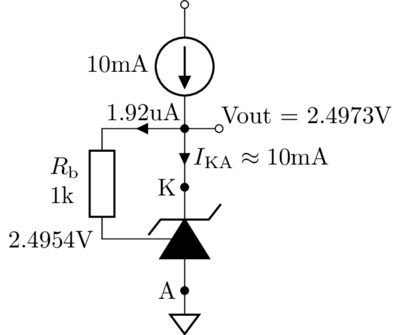

In [23]:
%%tikz -p circuitikz -s 400,400

\ctikzset{european resistors, american currents}

\draw (0, 0) node [sground] {} node[left] {A}
  to [zzD*, n=D, *-*] ++(0, 1.5) coordinate (K)
  node [left] {K};

\draw (D.center) to [short] ++(-1.2, 0)
  coordinate (R)  node [left] {2.4954V}
  to [R, l2={$R_\mathrm{b}$ and 1k}, bipoles/length=1.2cm] ++(0, 1.6)
  coordinate (R2)
  to [short, -*, i<={1.92uA}] (R2 -|D)
  to [short, i={$I_\mathrm{KA}\approx10\mathrm{mA}$}]  (K);

\draw (R2-|D) to [short, -o] ++(0.5, 0)
  ++(-0.1, 0.2) node [right] {Vout = 2.4973V};

\draw (R2 -|D) to [I, invert, l={10mA}] ++(0, 1.8) node [ocirc] {};


In [6]:
ng.circ('''
  I1 0 cathode 10m
  Rb cathode ref 1k

  Q1 cathode ref q1e NPN 1
  R4 q1e mid 3.28k
  R2 mid q2b 2.4k
  R3 mid q5b 7.2k
  Q2 q2b q2b 0 NPN 3
  Q3 q5b q2b r1 NPN 6
  R1 r1 0 800

  R7 cathode q7e 800
  Q7 q7b q7b q7e PNP
  Q4 q7b q1e q4e NPN 1
  R5 q4e q5c     4k
  Q5 q5c q5b 0   NPN 1

  R8 cathode q8e 800
  Q8 q9b q7b q8e PNP
  R6 q2b q6b 1k
  Q6 q9b q6b 0 NPN 1

  Q9 cathode q9b q9e NPN
  R9 q9e q10b 150
  Q10 cathode q10b 0 NPN 50
  R10 q10b 0 10k

  .options savecurrents
  .model NPN NPN(IS=1f BF=120 Cje=1p Cjc=2p VAF=80)
  .model PNP PNP(IS=10f BF=80 Cje=1p Cjc=2p VAF=80)
''')
ng.operating_point()

print_op()

@i1[current] = 10000.00 uA
  @q10[ib] =    77.46 uA
  @q10[ic] =  9507.25 uA
   @q1[ib] =     1.92 uA
   @q1[ic] =   230.42 uA
   @q2[ib] =     1.43 uA
   @q2[ic] =   171.61 uA
   @q3[ib] =     0.48 uA
   @q3[ic] =    57.36 uA
   @q4[ib] =     0.49 uA
   @q4[ic] =    59.16 uA
   @q5[ib] =     0.50 uA
   @q5[ic] =    59.66 uA
   @q6[ib] =     0.47 uA
   @q6[ic] =    56.68 uA
   @q7[ib] =    -0.72 uA
   @q7[ic] =   -57.72 uA
   @q8[ib] =    -0.72 uA
   @q8[ic] =   -57.86 uA
   @q9[ib] =     1.18 uA
   @q9[ic] =   143.40 uA
   @r10[i] =    67.12 uA
    @r1[i] =    57.84 uA
    @r2[i] =   173.99 uA
    @r3[i] =    57.86 uA
    @r4[i] =   231.84 uA
    @r5[i] =    59.66 uA
    @r6[i] =     0.47 uA
    @r7[i] =    58.45 uA
    @r8[i] =    58.58 uA
    @r9[i] =   144.57 uA
    @rb[i] =     1.92 uA
   cathode =  2497.31 mV
       mid =  1058.24 mV
      q10b =   671.16 mV
       q1e =  1818.68 mV
       q2b =   640.67 mV
       q4e =  1177.15 mV
       q5b =   641.66 mV
       q5c =   938.53 m

## Dynamic Impedance

Dynamic Impedance = 0.14 Ohm


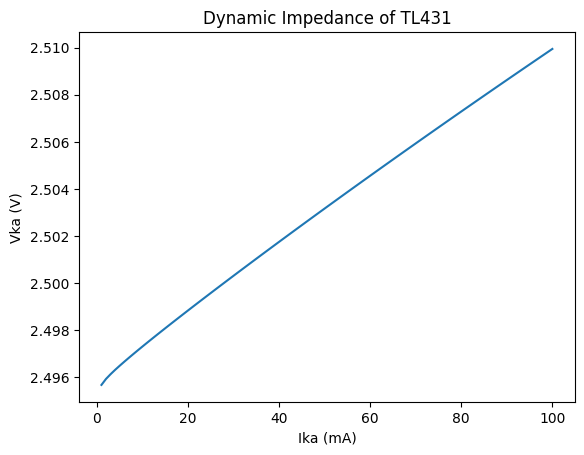

In [25]:
ng.cmd('dc i1 1m 100m 1m')
Ika = ng.vector('i-sweep')
Vout = ng.vector('cathode')
plt.plot(Ika*1e3, Vout)
plt.xlabel('Ika (mA)')
plt.ylabel('Vka (V)')
plt.title('Dynamic Impedance of TL431')
print('Dynamic Impedance = %.2f Ohm' % ((max(Vout)-min(Vout))/(max(Ika) - min(Ika))))

## DC Gain

TODO: